# Gaussian mixture model

In [1]:
# Load generated data from file:
import pickle

from evaluation import *

runs = []
num_chains = 10
for i in range(num_chains):
    with open(f"samples_produced/gmm_{i}__count1000_eps0.05_leapfrogsteps50.pickle", "rb") as f:
        runs.append(pickle.load(f))

In [2]:
from tqdm import tqdm

# Read Anglican files:
for i in tqdm(range(num_chains)):
    for method in anglican_methods:
        runs[i][method] = {}
        with open(f"anglican_samples/gmm/{method}{i}.txt") as f:
            contents = f.read()
            # Skip parentheses:
            assert contents[0] == "("
            assert contents[-1] == ")"
            contents = contents[1:-1]
            sample_list = contents.split("]] [[")
            # Skip "[[" at the start:
            assert sample_list[0][:2] == "[["
            sample_list[0] = sample_list[0][2:]
            # Skip "]]" at the end:
            assert sample_list[-1][-2:] == "]]"
            sample_list[-1] = sample_list[-1][:-2]
            # Parse each sample:
            sample_list = [
                [
                    [float(x) for x in mean.split()]
                    for mean in sample.split("] [")
                ]
                for sample in sample_list
            ]
            runs[i][method]["samples"] = sample_list

# Read timings:
if anglican_methods:
    timings = parse_anglican_timings("anglican_samples/gmm/timing.txt")
    for method in anglican_methods:
        for i in range(len(runs)):
            runs[i][method]["time"] = timings[method][i]

100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


In [3]:
thinned_runs = thin_runs(all_methods, runs)
chains = collect_chains(all_methods, thinned_runs)
print_running_time(all_methods, runs, thinned_runs)


Running times:
hmc: 1737.12s    0.1737s per sample (after thinning)
is: 622.02s    0.0622s per sample (after thinning)
lmh: 16571.80s    1.6572s per sample (after thinning)
pgibbs: 16835.43s    1.6835s per sample (after thinning)
rmh: 16376.18s    1.6376s per sample (after thinning)
ipmcmc: 3939.93s    0.3940s per sample (after thinning)


In [4]:
import torch
import math
import example_gmm as gmm

def gmm_lppd(samples):
    M = len(samples)
    N = len(gmm.test_data)
    #compute the probability density for each data point and sapmle (size M x N):
    logps = torch.stack([gmm.loglikelihoods(torch.tensor(sample), gmm.test_data) for sample in samples])
    # average over all samples:
    logp_avg = torch.logsumexp(logps, dim=0) - math.log(float(M))
    # sum over all test data points:
    lppd = torch.sum(logp_avg)
    return lppd

def gmm_lppd_stats(chains):
    lppds = torch.tensor([gmm_lppd(chain) for chain in chains])
    std, mean = torch.std_mean(lppds)
    return mean.item(), std.item()

def print_gmm_lppd_stats(chains):
    mean, std = gmm_lppd_stats(chains)
    return f"{mean:.2f} +- {std:.2f} (standard deviation)"

print("Log posterior predictive densities:")
print(f"True LPPD:  {print_gmm_lppd_stats([[gmm.data_means.tolist()]])}")
for method in all_methods:
    print(f"{method}:  {print_gmm_lppd_stats(chains[method])}")

Log posterior predictive densities:
True LPPD:  -674.81 +- nan (standard deviation)
hmc:  -675.54 +- 0.23 (standard deviation)
is:  -728.79 +- 9.98 (standard deviation)
lmh:  -675.78 +- 0.53 (standard deviation)
pgibbs:  -715.86 +- 1.29 (standard deviation)
rmh:  -675.84 +- 0.35 (standard deviation)
ipmcmc:  -708.51 +- 1.62 (standard deviation)


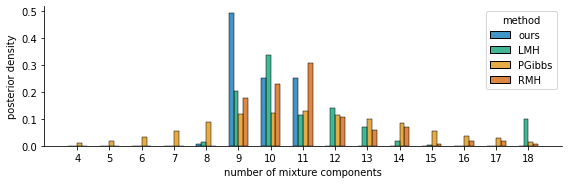

In [5]:
# Plot the number of mixture components
import pandas
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def toListOfKs(xss):
    return [len(x) for xs in xss for x in xs]

data = []
for method in compared_methods:
    data += [(method_name[method], k) for k in toListOfKs(chains[method])]

x_label = "number of mixture components"
dataframe = pandas.DataFrame(data, columns=["method", x_label])
plot = sns.displot(
    data=dataframe,
    x=x_label,
    hue="method",
    stat="density",
    common_norm=False,
    discrete=True,
    binrange=(4,18),
    multiple="dodge",
    shrink=0.6,
    aspect=3.0,
    facet_kws={"legend_out": False},
    palette=palette,
    height=8/3,
)
plot.set_ylabels(label="posterior density")
plt.xticks([i for i in range(4, 19)])
plot.savefig("gmm-histogram.pdf", bbox_inches="tight")

100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


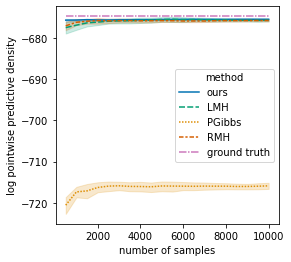

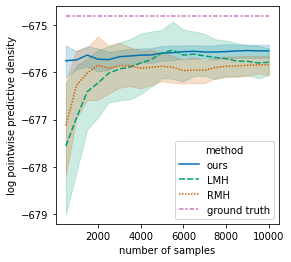

In [6]:
# graph LPPD progression:
from tqdm import tqdm
lppd_data = []
for i in tqdm(range(1, 21)):
    for method in compared_methods:
        num_chains = len(chains[method])
        num_samples = len(chains[method][0])
        n = i * num_samples // 20
        truncated_lppds = [gmm_lppd(chain[:n]).item() for chain in chains[method]]
        lppd_data += [(method_name[method], n * num_chains, lppd) for lppd in truncated_lppds]
    lppd_data.append(("ground truth", n * num_chains, gmm_lppd([gmm.data_means.tolist()]).item()))
df = pandas.DataFrame(lppd_data, columns=["method", "number of samples", "log pointwise predictive density"])
plt.figure(figsize=(4,4))
plot = sns.lineplot(
    data=df,
    x="number of samples",
    y="log pointwise predictive density",
    hue="method",
    style="method",
    palette=palette,
)
plt.show()
plot.get_figure().savefig("gmm-lppd-plot.pdf", bbox_inches="tight")

df_just_mhc = pandas.DataFrame([lppd for lppd in lppd_data if lppd[0] in ["ours", "LMH", "RMH", "ground truth"]], columns=["method", "number of samples", "log pointwise predictive density"])
plt.figure(figsize=(4,4))
plot = sns.lineplot(
    data=df_just_mhc,
    x="number of samples",
    y="log pointwise predictive density",
    hue="method",
    style="method",
    palette=palette,
)
plt.show()
plot.get_figure().savefig("gmm-lppd-zoomed-in.pdf", bbox_inches="tight")